<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand-vertical.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.978 · TFM Area 1</p>
<p style="margin: 0; text-align:right;">2023-1 · Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'informàtica, multimèdia i telecomunicació</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Àlex Franco Granell</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Prediction Models

In this notebook I will load the previously prepared data from the exploratory data analysis notebook, in order to find the best model to predict the data.

This one, unlike the other one, is specifically a workbook, so I won't comment on the results each time. These results are discussed in the work report.

**Index of contents**:

    1. Prediction model search
    
     1.1. Testing the Knn algorithm
     
     1.2. Testing the RandomForest algorithm
     
     1.3. Testing the logistic regression algorithm
     
     1.4. Testing the SVC algotithm
     
     1.5. Testing neural network
     
     1.6. Testing RandomForest Balanced
     
     1.7. Testing SVC Balanced
     
    2. Final Prediction Model
 
     2.1. Final parameter tuning
     
     2.2. Prediction model


If you just want to run the best model, run this notebook with MODEL_SEARCH & TRAIN_FINAL_MODEL = False and go straight to section 2. 




In [3]:
# Execution control:
MODEL_SEARCH = True
TRAIN_FINAL_MODEL = True

if MODEL_SEARCH == True:
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install scipy
    !pip install tensorflow

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc

# Get the data
data = pd.read_csv(r"./Data/SpeedDating_processed.csv")

PLOT_COUNT = 21
GLOBAL_STRATEGY = 'SMOTE'

# Resample method:
def match_method(strategy, X_train, y_train):
    if strategy == 'SMOTE':
        smote = SMOTE(random_state=42)
        return smote.fit_resample(X_train, y_train)
    elif strategy == 'RESAMPLE':
        rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
        return rus.fit_resample(X_train, y_train)
        

# Importance of different attributes in a couple (other): [0-15], [16-20], [21-100]
pref_importance_other = ['d_pref_o_attractive',
                         'd_pref_o_sincere',
                         'd_pref_o_intelligence', 
                         'd_pref_o_funny',
                         'd_pref_o_ambitious',
                         'd_pref_o_shared_interests']

# Rating of the other on the user: [0-5], [6-8], [9-10]
rate_other_me = ['d_attractive_o', 
                 'd_sinsere_o', 
                 'd_intelligence_o',  
                 'd_funny_o',
                 'd_ambitous_o',
                 'd_shared_interests_o']

# Importance of different attributes in a couple (user): [0-15], [16-20], [21-100]
pref_importance_me = ['d_attractive_important', 
                      'd_sincere_important', 
                      'd_intellicence_important',
                      'd_funny_important',
                      'd_ambtition_important', 
                      'd_shared_interests_important']

# Self-perception of the user: [0-5], [6-8], [9-10]
self_perception = ['d_attractive', 
                   'd_sincere',  
                   'd_intelligence', 
                   'd_funny',  
                   'd_ambition']

# Score of the user over the other: [0-5], [6-8], [9-10]
rate_me_other = ['d_attractive_partner', 
                 'd_sincere_partner', 
                 'd_intelligence_partner', 
                 'd_funny_partner', 
                 'd_ambition_partner',
                 'd_shared_interests_partner']

# User interests: [0-5], [6-8], [9-10]
interest = ['d_sports',
            'd_tvsports', 
            'd_exercise', 
            'd_dining', 
            'd_museums',
            'd_art',
            'd_hiking',
            'd_gaming', 
            'd_clubbing',
            'd_reading', 
            'd_tv', 
            'd_theater',
            'd_movies', 
            'd_concerts', 
            'd_music', 
            'd_shopping', 
            'd_yoga']

# Remove unnecessary attributes
data = data.drop('Unnamed: 0', axis=1)
data = data.drop(interest, axis=1)
data = data.drop(rate_other_me, axis=1)
data = data.drop(rate_me_other, axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7802 entries, 0 to 7801
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        7802 non-null   int64  
 1   age                           7802 non-null   float64
 2   age_o                         7802 non-null   float64
 3   d_d_age                       7802 non-null   int64  
 4   race                          7802 non-null   int64  
 5   race_o                        7802 non-null   int64  
 6   samerace                      7802 non-null   int64  
 7   d_importance_same_race        7802 non-null   int64  
 8   d_importance_same_religion    7802 non-null   int64  
 9   field                         7802 non-null   int64  
 10  d_pref_o_attractive           7802 non-null   int64  
 11  d_pref_o_sincere              7802 non-null   int64  
 12  d_pref_o_intelligence         7802 non-null   int64  
 13  d_p

## 1. Prediction model search

### 1.1. Testing the Knn algorithm

C:\Users\afran\.conda\envs\TFM\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\afran\.conda\envs\TFM\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Best accuracy is for k=2 with 0.74%


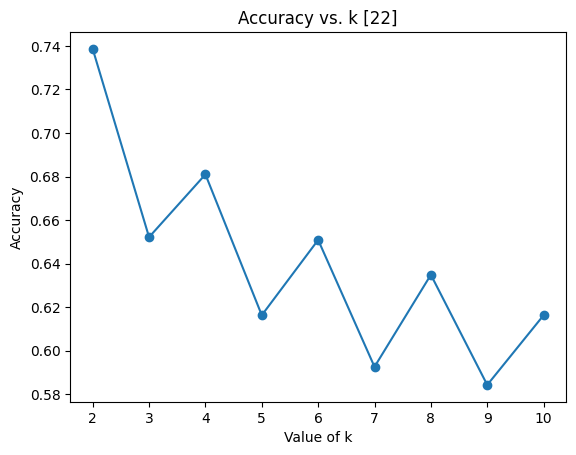

CPU times: total: 5.91 s
Wall time: 672 ms


In [5]:
%%time
if MODEL_SEARCH == True:
    from sklearn.neighbors import KNeighborsClassifier

    X = data.drop(['match'], axis=1)
    y = data['match']

    # train / test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Resample
    X_train_resampled, y_train_resampled = match_method(GLOBAL_STRATEGY, X_train, y_train)

    # k values to test
    k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

    accuracy_scores = []

    best = 0

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_resampled, y_train_resampled)

        y_pred = knn.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

    best = np.argmax(accuracy_scores)
    print(f"Best accuracy is for k={k_values[best]} with {round(accuracy_scores[best], 2)}%")

    PLOT_COUNT +=1
    plt.plot(k_values, accuracy_scores, marker='o')
    plt.xlabel('Value of k')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. k [{PLOT_COUNT}]')
    plt.show()

Confusion Matrix:
 [[674 627]
 [ 83 177]]


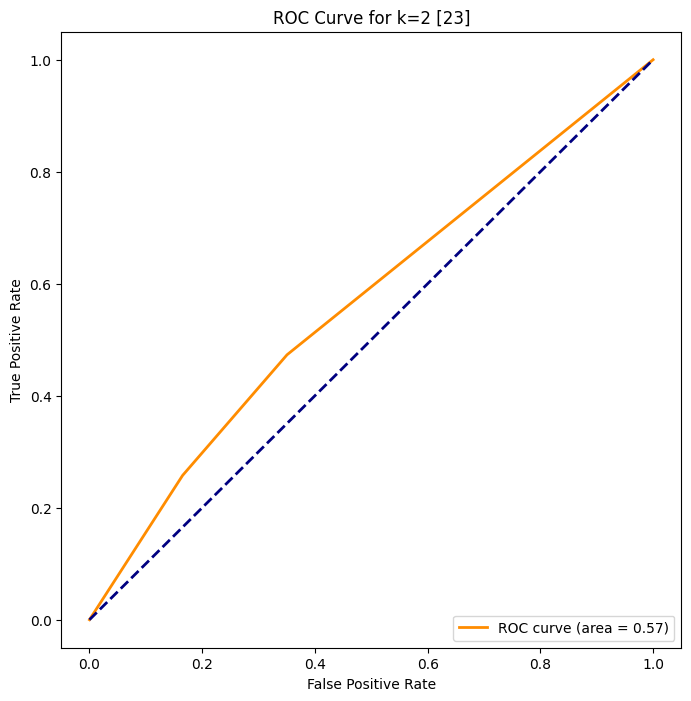

CPU times: total: 1.59 s
Wall time: 165 ms


In [4]:
%%time
if MODEL_SEARCH == True:
    # Evaluate the model
    best_k_value = k_values[best]

    knn_best = KNeighborsClassifier(n_neighbors=best_k_value)
    knn_best.fit(X_train_resampled, y_train_resampled)

    y_prob_best = knn_best.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob_best)
    roc_auc = auc(fpr, tpr)
    
    y_pred = knn.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)

    PLOT_COUNT +=1
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for k={best_k_value} [{PLOT_COUNT}]')
    plt.legend(loc='lower right')
    plt.show()

### 1.2. Testing the RandomForest algorithm

In [5]:
%%time
if MODEL_SEARCH == True:
    from sklearn.ensemble import RandomForestClassifier
        
    X = data.drop(['match'], axis=1)
    y = data['match']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Resample
    X_train_resampled, y_train_resampled = match_method(GLOBAL_STRATEGY, X_train, y_train)

    # Try params:
    num_trees_list = [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]

    cv_scores  = []

    for num_trees in num_trees_list:
        print(f"testing tree with: {num_trees}")
        random_forest = RandomForestClassifier(n_estimators=num_trees, random_state=42)
        scores = cross_val_score(random_forest, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')

        mean_score = np.mean(scores)
        cv_scores.append(mean_score)

    best_num_trees = num_trees_list[np.argmax(cv_scores)]
    print(f"Best ROC-AUC is for Num_trees={best_num_trees} with {round(max(cv_scores), 2)} (cross-validated)")

    final_random_forest = RandomForestClassifier(n_estimators=best_num_trees, random_state=42)
    final_random_forest.fit(X_train_resampled, y_train_resampled)

    y_pred = final_random_forest.predict(X_test)

    roc_auc_test = roc_auc_score(y_test, y_pred)
    print(f"Final ROC-AUC on test set: {round(roc_auc_test, 2)}")

testing tree with: 300
testing tree with: 350
testing tree with: 400
testing tree with: 450
testing tree with: 500
testing tree with: 550
testing tree with: 600
testing tree with: 650
testing tree with: 700
testing tree with: 750
testing tree with: 800
Best ROC-AUC is for Num_trees=800 with 0.98 (cross-validated)
Final ROC-AUC on test set: 0.53
CPU times: total: 5min 53s
Wall time: 5min 59s


Confusion Matrix:
 [[1270   31]
 [ 239   21]]


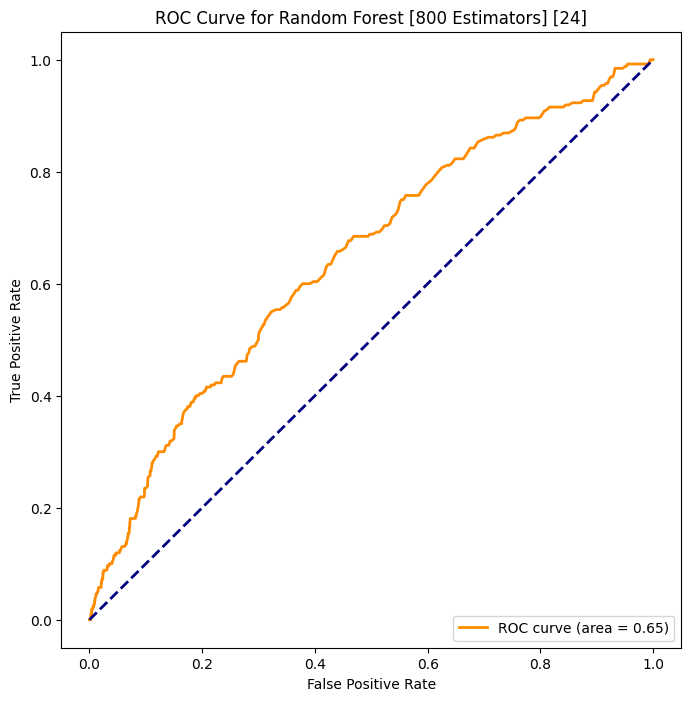

CPU times: total: 11.6 s
Wall time: 11.9 s


In [6]:
%%time
if MODEL_SEARCH == True:
    random_forest = RandomForestClassifier(n_estimators=best_num_trees, random_state=42)
    random_forest.fit(X_train_resampled, y_train_resampled)

    y_pred = random_forest.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)

    PLOT_COUNT +=1
    y_prob = random_forest.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Random Forest [{best_num_trees} Estimators] [{PLOT_COUNT}]')
    plt.legend(loc='lower right')
    plt.show()

In [7]:
if MODEL_SEARCH == True:
    importances = random_forest.feature_importances_

    # Get tuples (feature, importance)
    sorted_importances = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)

    for feature, importance in sorted_importances:
        print(f'{feature}: {round(importance,3)}')

d_d_age: 0.088
d_pref_o_funny: 0.071
interests_correlate: 0.065
age_o: 0.064
d_pref_o_sincere: 0.057
field: 0.053
age: 0.05
d_funny_important: 0.041
d_pref_o_intelligence: 0.039
d_pref_o_shared_interests: 0.039
d_pref_o_attractive: 0.035
d_importance_same_race: 0.034
race_o: 0.033
d_funny: 0.029
d_sincere_important: 0.027
d_importance_same_religion: 0.027
d_intellicence_important: 0.026
d_pref_o_ambitious: 0.025
d_sincere: 0.024
d_shared_interests_important: 0.024
race: 0.023
d_intelligence: 0.023
d_ambition: 0.023
d_attractive_important: 0.023
d_attractive: 0.02
samerace: 0.013
d_ambtition_important: 0.013
gender: 0.01


### 1.3. Testing the logistic regression algorithm

Confusion Matrix:
 [[770 531]
 [113 147]]


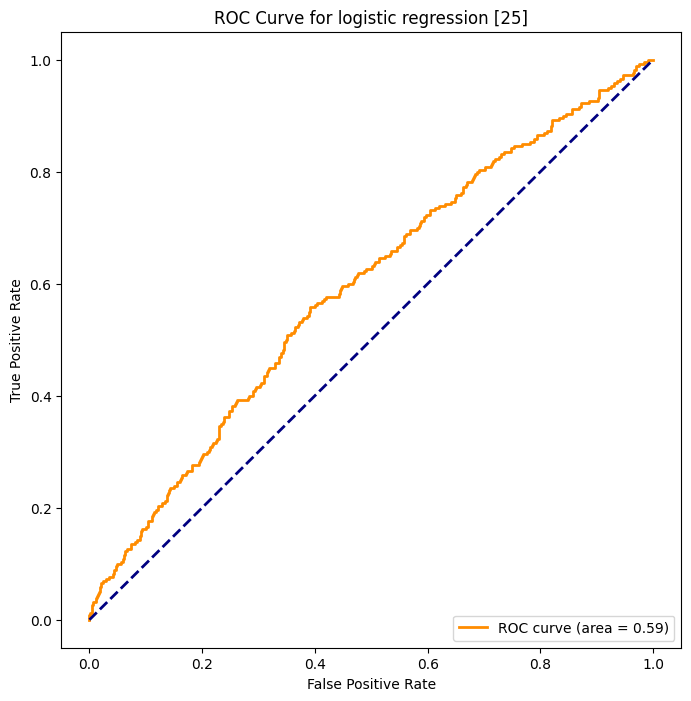

CPU times: total: 46.9 ms
Wall time: 121 ms


In [8]:
%%time
if MODEL_SEARCH == True:
    from sklearn.linear_model import LogisticRegression

    X = data.drop(['match'], axis=1)
    y = data['match']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Resample
    X_train_resampled, y_train_resampled = match_method(GLOBAL_STRATEGY, X_train, y_train)

    logistic_regression = LogisticRegression(random_state=42)
    logistic_regression.fit(X_train_resampled, y_train_resampled)

    y_pred = logistic_regression.predict(X_test)
    y_prob_best = logistic_regression.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob_best)
    roc_auc = auc(fpr, tpr)
    
    y_pred = logistic_regression.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)

    PLOT_COUNT +=1
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for logistic regression [{PLOT_COUNT}]')
    plt.legend(loc='lower right')
    plt.show()

### 1.4. Testing SVC algorithm

Confusion Matrix:
 [[1026  275]
 [ 155  105]]


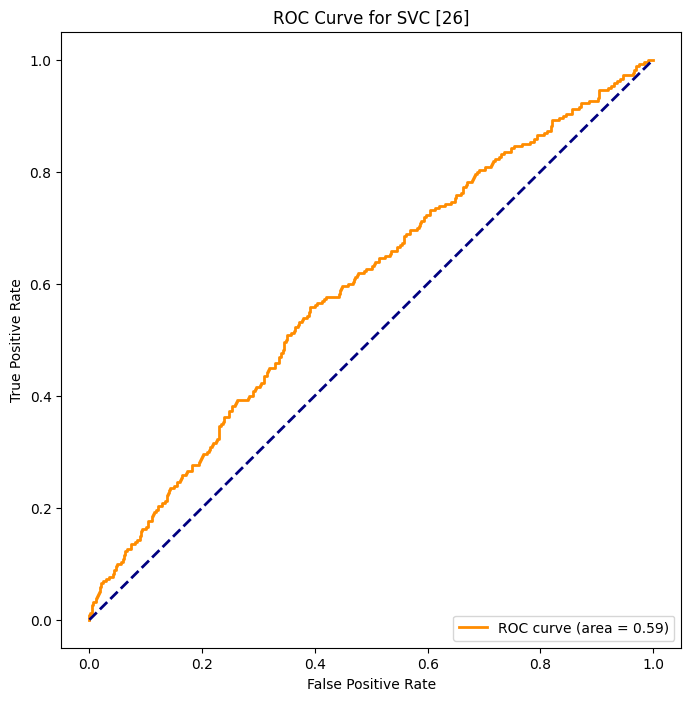

CPU times: total: 3 s
Wall time: 2.81 s


In [9]:
%%time
if MODEL_SEARCH == True:
    from sklearn.svm import SVC
    
    X = data.drop(['match'], axis=1)
    y = data['match']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Resample
    X_train_resampled, y_train_resampled = match_method(GLOBAL_STRATEGY, X_train, y_train)

    svm_classifier = SVC(random_state=42)

    svm_classifier.fit(X_train_resampled, y_train_resampled)

    y_pred = svm_classifier.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)

    PLOT_COUNT +=1
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for SVC [{PLOT_COUNT}]')
    plt.legend(loc='lower right')
    plt.show()

### 1.5. Testing neural network




Epoch 1/10


325/325 [==============================] - 1s 2ms/step - loss: 0.6767 - accuracy: 0.5803 - val_loss: 0.6395 - val_accuracy: 0.6214
Epoch 2/10
325/325 [==============================] - 0s 1ms/step - loss: 0.6355 - accuracy: 0.6401 - val_loss: 0.6272 - val_accuracy: 0.6374
Epoch 3/10
325/325 [==============================] - 0s 1ms/step - loss: 0.6055 - accuracy: 0.6741 - val_loss: 0.5882 - val_accuracy: 0.6765
Epoch 4/10
325/325 [==============================] - 0s 1ms/step - loss: 0.5848 - accuracy: 0.6933 - val_loss: 0.6135 - val_accuracy: 0.6521
Epoch 5/10
325/325 [==============================] - 0s 1ms/step - loss: 0.5652 - accuracy: 0.7096 - val_loss: 0.5959 - val_accuracy: 0.6714
Epoch 6/10
325/325 [==============================] - 0s 1ms/step - loss: 0.5473 - accuracy: 0.7231 - val_loss: 0.5604 - val_accuracy: 0.7002
Epoch 7/10
325/325 [==============================] - 0s 1ms/step - loss: 0.5277 - accuracy: 0.7400 - val_loss: 0.5513 - val_accuracy: 0.7130
E

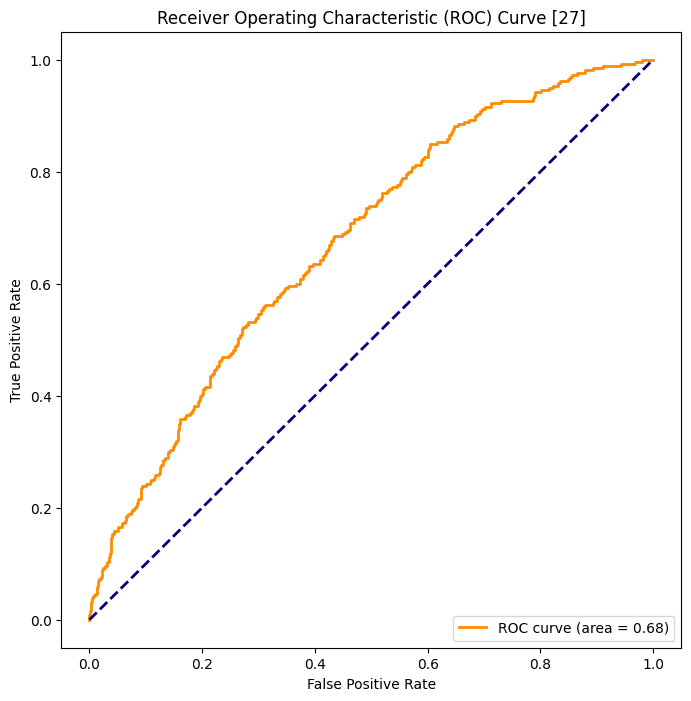

CPU times: total: 2.28 s
Wall time: 9.31 s


In [10]:
%%time
if MODEL_SEARCH == True:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout

    X = data.drop('match', axis=1)
    y = data['match']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Resample
    X_train, y_train = match_method(GLOBAL_STRATEGY, X_train, y_train)

    model = Sequential()
    model.add(Dense(320, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


    y_pred_proba = model.predict(X_test)
    

    y_pred = (y_pred_proba > 0.5).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    PLOT_COUNT += 1
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve [{PLOT_COUNT}]')
    plt.legend(loc='lower right')
    plt.show()

### 1.6. Testing RandomForest Balanced

In [11]:
%%time
if MODEL_SEARCH == True:
    from sklearn.ensemble import RandomForestClassifier
        
    X = data.drop(['match'], axis=1)
    y = data['match']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

     # Resample
    X_train_resampled, y_train_resampled = match_method(GLOBAL_STRATEGY, X_train, y_train)

    # Try params:
    num_trees_list = [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]

    cv_scores  = []

    for num_trees in num_trees_list:
        print(f"testing tree with: {num_trees}")
        random_forest = RandomForestClassifier(n_estimators=num_trees, class_weight='balanced', random_state=42)
        scores = cross_val_score(random_forest, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')

        mean_score = np.mean(scores)
        cv_scores.append(mean_score)

    best_num_trees = num_trees_list[np.argmax(cv_scores)]
    print(f"Best ROC-AUC is for Num_trees={best_num_trees} with {round(max(cv_scores), 2)} (cross-validated)")

    final_random_forest = RandomForestClassifier(n_estimators=best_num_trees, class_weight='balanced', random_state=42)
    final_random_forest.fit(X_train_resampled, y_train_resampled)

    y_pred = final_random_forest.predict(X_test)

    roc_auc_test = roc_auc_score(y_test, y_pred)
    print(f"Final ROC-AUC on test set: {round(roc_auc_test, 2)}")

testing tree with: 300
testing tree with: 350
testing tree with: 400
testing tree with: 450
testing tree with: 500
testing tree with: 550
testing tree with: 600
testing tree with: 650
testing tree with: 700
testing tree with: 750
testing tree with: 800
Best ROC-AUC is for Num_trees=800 with 0.98 (cross-validated)
Final ROC-AUC on test set: 0.53
CPU times: total: 5min 57s
Wall time: 6min 4s


Confusion Matrix:
 [[1270   31]
 [ 239   21]]


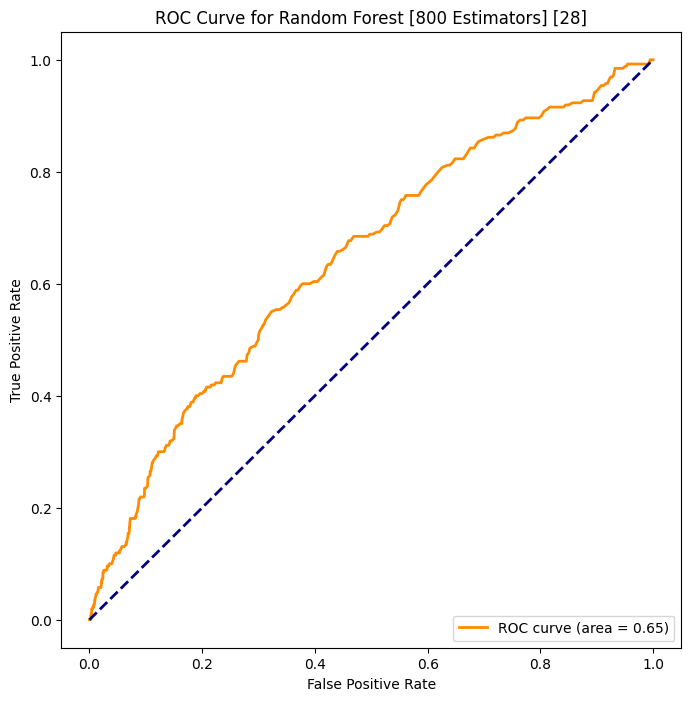

CPU times: total: 11.8 s
Wall time: 12 s


In [12]:
%%time
if MODEL_SEARCH == True:
    random_forest = RandomForestClassifier(n_estimators=best_num_trees, class_weight='balanced', random_state=42)
    random_forest.fit(X_train_resampled, y_train_resampled)

    y_pred = random_forest.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)

    PLOT_COUNT +=1
    y_prob = random_forest.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Random Forest [{best_num_trees} Estimators] [{PLOT_COUNT}]')
    plt.legend(loc='lower right')
    plt.show()

### 1.7. Testing SVC Balanced

Confusion Matrix:
 [[1026  275]
 [ 155  105]]


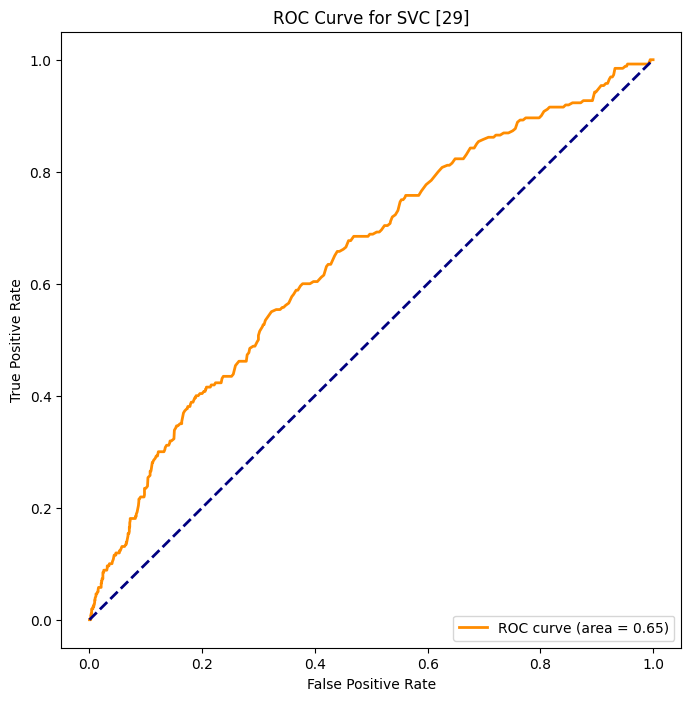

CPU times: total: 2.97 s
Wall time: 2.88 s


In [13]:
%%time
if MODEL_SEARCH == True:
    from sklearn.svm import SVC
    
    X = data.drop(['match'], axis=1)
    y = data['match']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
     # Resample
    X_train_resampled, y_train_resampled = match_method(GLOBAL_STRATEGY, X_train, y_train)
    
    svm_classifier = SVC(class_weight='balanced', random_state=42)

    svm_classifier.fit(X_train_resampled, y_train_resampled)

    y_pred = svm_classifier.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)

    PLOT_COUNT +=1
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for SVC [{PLOT_COUNT}]')
    plt.legend(loc='lower right')
    plt.show()

# 2. Final Prediction Model

After many tests with different parameters, I have seen that the algorithm that gives the best results to solve the problem is neural networks. In this section we will iterate over several parameters in order to profile it as much as possible for our interests and save it. The entire test suite with the different algorithms and columns can be found in the memory appendix.

For reference, my best parameters were {'batch_size': 256, 'epochs': 20, 'optimizer': 'rmsprop'}.

## 2.1. Final parameter tuning

In [14]:
if TRAIN_FINAL_MODEL == True:
    !pip install scikeras

In [6]:
def create_model(optimizer='adam'):
        model = Sequential()
        model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
        model.add(Dropout(0.5))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

if TRAIN_FINAL_MODEL == True:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import confusion_matrix, roc_curve, auc
    from sklearn.model_selection import GridSearchCV
    from scikeras.wrappers import KerasClassifier
    from tensorflow.keras.callbacks import EarlyStopping


    X = data.drop('match', axis=1)
    y = data['match']

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train / test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Resample
    X_train, y_train = match_method(GLOBAL_STRATEGY, X_train, y_train)

    # Model
    model = KerasClassifier(model=create_model, verbose=0)

    # Hyperparameter optimization
    param_grid = {
        'epochs': [5, 10, 20, 30, 40, 50, 75, 100, 250],
        'batch_size': [2, 4, 8, 12, 16, 20, 25, 30, 40, 50],
        'optimizer': ['adam', 'rmsprop', 'sgd']
    }

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall', cv=5)
    grid_result = grid.fit(X_train, y_train)
    
    print("Grid search done!")

Grid search done!


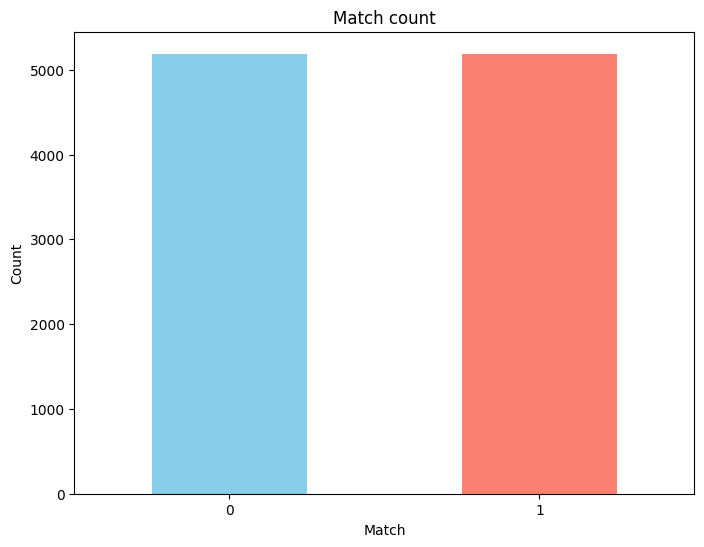

In [22]:
if TRAIN_FINAL_MODEL == True:
    plt.figure(figsize=(8, 6))
    y_train.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Match count')
    plt.xlabel('Match')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

Epoch 1/50
649/649 [==============================] - 1s 1ms/step - loss: 0.6668 - accuracy: 0.6052 - val_loss: 0.6465 - val_accuracy: 0.6105
Epoch 2/50
649/649 [==============================] - 1s 1ms/step - loss: 0.6142 - accuracy: 0.6678 - val_loss: 0.5958 - val_accuracy: 0.6592
Epoch 3/50
649/649 [==============================] - 1s 1ms/step - loss: 0.5786 - accuracy: 0.7047 - val_loss: 0.5716 - val_accuracy: 0.6874
Epoch 4/50
649/649 [==============================] - 1s 1ms/step - loss: 0.5522 - accuracy: 0.7257 - val_loss: 0.5280 - val_accuracy: 0.7316
Epoch 5/50
649/649 [==============================] - 1s 1ms/step - loss: 0.5391 - accuracy: 0.7404 - val_loss: 0.5323 - val_accuracy: 0.7252
Epoch 6/50
649/649 [==============================] - 1s 1ms/step - loss: 0.5211 - accuracy: 0.7545 - val_loss: 0.5332 - val_accuracy: 0.7239
Epoch 7/50
49/49 [==============================] - 0s 583us/step

Confusion Matrix:
 [[1035  266]
 [ 153  107]]


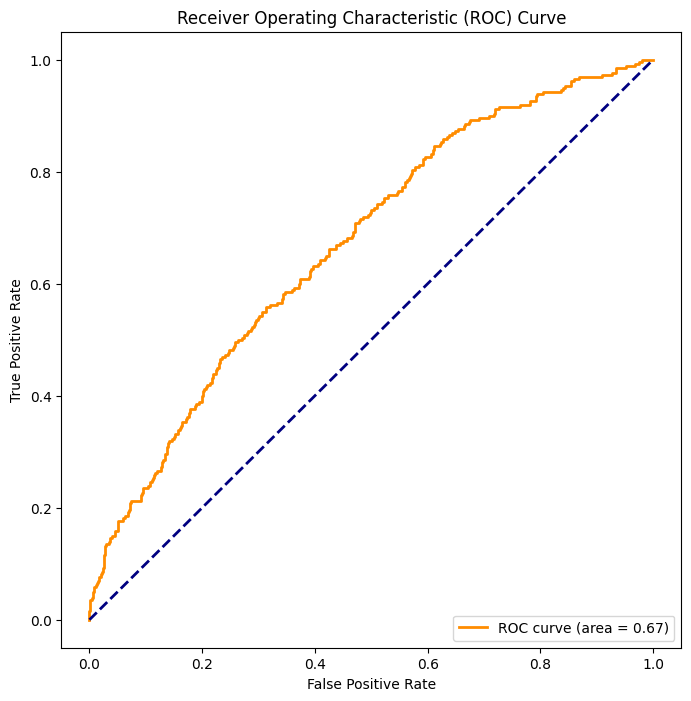

In [23]:
if TRAIN_FINAL_MODEL == True:
    # Best parameters
    best_params = grid_result.best_params_
    
    # Final model
    final_model = create_model(optimizer=best_params['optimizer'])

    # Callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Final model train
    final_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'],
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Prediction
    y_pred_proba = final_model.predict(X_test)

    
    # Adjust classification threshold
    new_threshold = 0.50
    y_pred = (y_pred_proba > new_threshold).astype(int)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', conf_matrix)

    # Plot ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [18]:
if TRAIN_FINAL_MODEL == True:
    print("Best Parameters:", best_params)

    # Save model if you like the results:
    final_model.save("./Model/prediction_model.keras")

Best Parameters: {'batch_size': 16, 'epochs': 50, 'optimizer': 'rmsprop'}


## 2.2. Prediction model

Last model saved was:

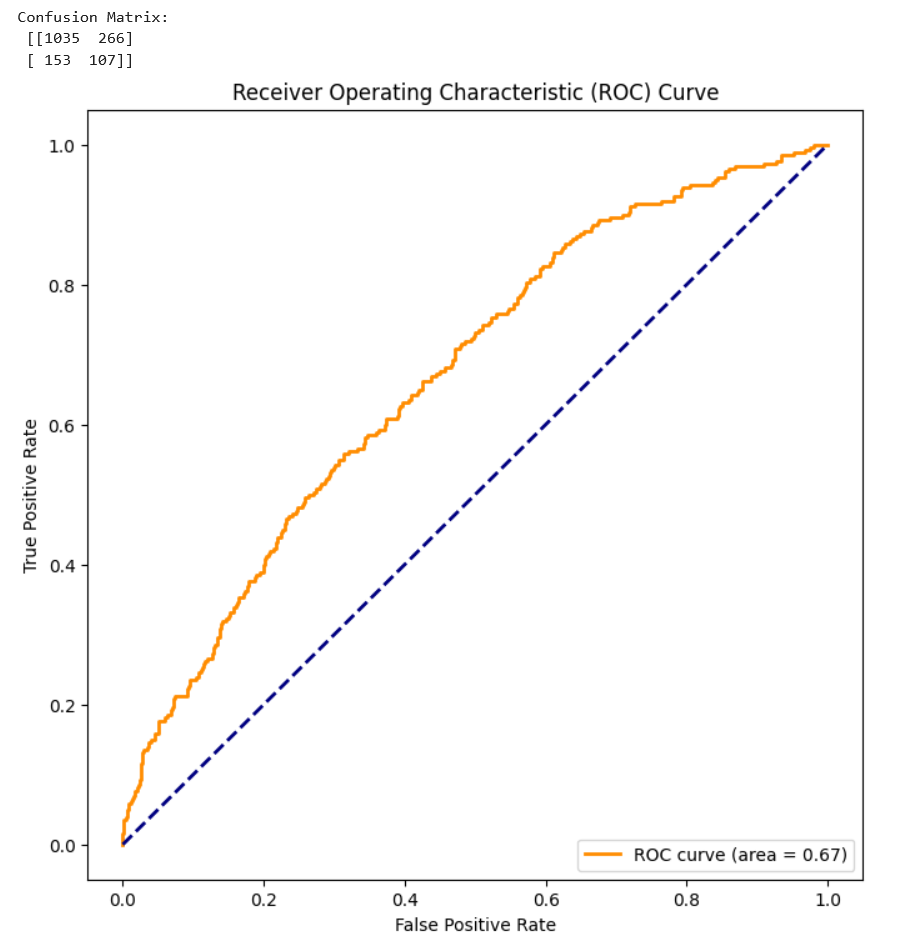

Here you can test your custom parameters, adjust at will:

In [19]:
user_dict = {
    "gender": 0,                            # {'female': 0, 'male': 1}
    "age": 24,                              # Numeric
    "race": 0,                              # {'European/Caucasian-American': 0,'Latino/Hispanic American': 1,'Black/African American': 2,'Asian/Pacific Islander/Asian-American': 3,'Other': 4}
    "d_importance_same_race": 0,            # {'[0-1]': 0, '[2-5]': 1, '[6-10]': 2}
    "d_importance_same_religion": 0,        # {'[0-1]': 0, '[2-5]': 1, '[6-10]': 2}
    "field": 6,                             # Numeric (check Exploratory analysis notebook)
    "d_attractive_important": 0,            # {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}
    "d_sincere_important": 2,               # {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}
    "d_intellicence_important": 1,          # {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}
    "d_funny_important": 0,                 # {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}
    "d_ambtition_important": 2,             # {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}
    "d_shared_interests_important": 1,      # {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}
    "d_attractive": 0,                      # {'[0-5]': 0, '[6-8]': 1, '[9-10]': 2}
    "d_sincere": 2,                         # {'[0-5]': 0, '[6-8]': 1, '[9-10]': 2}
    "d_intelligence": 1,                    # {'[0-5]': 0, '[6-8]': 1, '[9-10]': 2}
    "d_funny": 1,                           # {'[0-5]': 0, '[6-8]': 1, '[9-10]': 2}
    "d_ambition": 2                         # {'[0-5]': 0, '[6-8]': 1, '[9-10]': 2}
}

other_dict = {
    "age_o": 23,                            # Numeric
    "race_o": 0,                            # Numeric
    "d_pref_o_attractive": 0,               # {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}
    "d_pref_o_sincere": 2,                  # {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}
    "d_pref_o_intelligence": 1,             # {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}
    "d_pref_o_funny": 2,                    # {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}
    "d_pref_o_ambitious": 0,                # {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}
    "d_pref_o_shared_interests": 2,         # {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}
}
    




# Map d_d_age:
intervals = {'[0-1]': 0, '[2-3]': 1, '[4-6]': 2, '[7-37]': 3}

d_d_age = abs(user_dict["age"]-other_dict["age_o"])

for key, cat in intervals.items():
    min_val, max_val = map(int, key.strip('[]').split('-'))
    if min_val <= d_d_age <= max_val:
        categoria = cat
        break
        
# Map samerace:
samerace = 1 if user_dict["race"] == other_dict["race_o"] else 0
        
# In a realistic application scenario, this should be calculated by adding all the interests and correlating them.
# For simplicity, we'll use a number
interests_correlate = 0.45


############################### Test row ###############################

df = pd.DataFrame()

user_variables = [
    "gender", "age", "race", "d_importance_same_race", "d_importance_same_religion",
    "field", "d_attractive_important", "d_sincere_important", "d_intellicence_important",
    "d_funny_important", "d_ambtition_important", "d_shared_interests_important",
    "d_attractive", "d_sincere", "d_intelligence", "d_funny", "d_ambition"
]

other_variables = [
    "age_o", "race_o", "d_pref_o_attractive", "d_pref_o_sincere", "d_pref_o_intelligence",
    "d_pref_o_funny", "d_pref_o_ambitious", "d_pref_o_shared_interests"
]

for var in user_variables:
    df[var] = [user_dict[var]]

for var in other_variables:
    df[var] = [other_dict[var]]

df["d_d_age"] = [d_d_age]
df["samerace"] = [samerace]
df["interests_correlate"] = [interests_correlate]

df.head()

,gender,age,race,d_importance_same_race,d_importance_same_religion,field,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,...,race_o,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,d_d_age,samerace,interests_correlate
0,0,24,0,0,0,6,0,2,1,0,...,0,0,2,1,2,0,2,1,1,0.45


 Now we can test the model with our new data:

In [20]:
from tensorflow.keras.models import load_model

final_model = load_model("./Model/prediction_model.keras")

X_test = df.values

# Scale
X_test = scaler.fit_transform(X_test)

predictions = final_model.predict(X_test)

# This number must be the same as the training data one. For my model keep it as 0.50
new_threshold = 0.50  
predictions = (predictions > new_threshold).astype(int)

if predictions == 1:
    print("You have a match!")
else:
    print("Better luck next time!")

1/1 [==============================] - 0s 27ms/step
You have a match!
